In [123]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import numpy as np
import matplotlib.pyplot as plt
from hottbox.core import Tensor, TensorTKD
from hottbox.algorithms.decomposition import HOSVD, HOOI
from hottbox.utils.generation import residual_tensor
from coursework.data import get_image, plot_tensors

In [125]:
np.random.seed(0)

[Return to Table of Contents](./0_Table_of_contents.ipynb)

# Tucker Decomposition

<img src="./imgs/TensorTKD.png" alt="Drawing" style="width: 500px;"/>

In previous [assignment](./2_Efficient_representation_of_multidimensional_arrays.ipynb), you have been provided materials which cover efficient representations of mutlidimensional arrays of data, such as the Tucker form. In this module, you will take a closer look at it and the assiciated computational methods.


Any tensor of arbitrarily large order can be decomposed in the Tucker form. As illustrated above, a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I \times J \times K}$ can be represented as a dense core tensor $\mathbf{\underline{G}}$ and a set of factor matrices $\mathbf{A} \in \mathbb{R}^{I \times Q}, \mathbf{B} \in \mathbb{R}^{J \times R}$ and $\mathbf{C} \in
\mathbb{R}^{K \times P}$

$$
\mathbf{\underline{X}} = \mathbf{\underline{G}} \times_1 \mathbf{A} \times_2 \mathbf{B} \times_3 \mathbf{C} = \Big[    \mathbf{\underline{G}} ;  \mathbf{A},  \mathbf{B}, \mathbf{C}      \Big]
$$


On practice, there exist several computational methods to accomplish this all of which are combined into a Tucker Decomposition framework. The two most commonly used algorithms are:
1. Higher Order Singular Value Decomposition ([HOSVD](#Higher-Order-Singular-Value-Decomposition-(HOSVD)))
1. Higher Order Orthogonal Iteration ([HOOI](#Higher-Order-Orthogonal-Iteration-(HOOI)))


# Higher Order Singular Value Decomposition (HOSVD)

The HOSVD is a special case of the Tucker decomposition, in which all the factor matrices are constrained to be orthogonal. They are computed as truncated version of the left singular matrices of all possible mode-$n$ unfoldings of tensor $\mathbf{\underline{X}}$:

$$
\begin{aligned}
\mathbf{X}_{(1)} &= \mathbf{U}_1  \mathbf{\Sigma}_1 \mathbf{V}_1^T \quad \rightarrow \quad \mathbf{A} = \mathbf{U}_1[1:R_1]\\
\mathbf{X}_{(2)} &= \mathbf{U}_2  \mathbf{\Sigma}_2 \mathbf{V}_2^T \quad \rightarrow \quad \mathbf{B} = \mathbf{U}_2[1:R_2] \\
\mathbf{X}_{(3)} &= \mathbf{U}_3  \mathbf{\Sigma}_3 \mathbf{V}_3^T \quad \rightarrow \quad \mathbf{C} = \mathbf{U}_3[1:R_3] \\
\end{aligned}
$$

After factor matrices are obtained, the core tensor $\mathbf{\underline{G}}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^T \times_2 \mathbf{B}^T \times_3 \mathbf{C}^T        
$$


# Higher Order Orthogonal Iteration (HOOI)

HOOI algorithm is another special case of the Tuker decomposition. Like HOSVD, it decomposes a tensor into a dense core tensor and orthogonal factor matrices. The difference between the two lies in the fact that in HOOI the factor matrices are optimized iteratively using an Alternating Least Squares (ALS) approach. In other words, the tucker representation $[ \mathbf{\underline{G}};\mathbf{A}^{(1)}, \mathbf{A}^{(2)}, \cdots,\mathbf{A}^{(N)} ]$ of the given tensor $\mathbf{\underline{X}}$ is obtained through the HOOI as follows

$$
\begin{aligned}
&\mathbf{\underline{Y}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T} \times_2 \cdots \times_{n-1} \mathbf{A}^{(n-1)T} \times_{n+1} \mathbf{A}^{(n+1)} \times \cdots \times_N \mathbf{A}^{(N)} \\
&\mathbf{A}^{(n)} \leftarrow R_n \text{ leftmost singular vectors of } \mathbf{Y}_{(n)}
\end{aligned}
$$

The above is repeated until convergence, then the core tensor $\mathbf{\underline{G}} \in \mathbb{R}^{R_1 \times R_2 \times \cdots \times R_N}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T}  \times_2 \mathbf{A}^{(2)T} \times_3 \cdots  \times_N \mathbf{A}^{(N)T}
$$

# Multi-linear rank

The **multi-linear rank** of a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I_1 \times \cdots \times I_N}$ is the $N$-tuple $(R_1, \dots, R_N)$ where each $R_n$ is the rank of the subspace spanned by mode-$n$ fibers, i.e. $R_n = \text{rank} \big( \mathbf{X}_{(n)} \big)$. Thus, for our order-$3$ tensor the multi-linear rank is $(R_1, R_2, R_3)$. Multi-linear rank provides flexibility in compression and approximation of the original tensor.

> **NOTE:** For a tensor of order $N$ the values $R_1, R_2, \dots , R_N$ are not necessarily the same, whereas, for matrices (tensors of order 2) the equality $R_1 = R_2$ always holds, where $R_1$ and $R_2$ are the matrix column rank and row rank respectively.



# Performing tensor decomposition

In [126]:
# Create tensor
I, J, K = 5, 6, 7
array_3d = np.random.rand(I * J * K).reshape((I, J, K)).astype(np.float64)
tensor = Tensor(array_3d)

# Initialise algorithm
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 5, 6)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(4, 5, 6).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (5, 6, 7) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (5, 4)
Mode-1 factor matrix is of shape (6, 5)
Mode-2 factor matrix is of shape (7, 6)

	Core tensor
This tensor is of order 3 and consists of 120 elements.
Sizes and names of its modes are (4, 5, 6) and ['mode-0', 'mode-1', 'mode-2'] respectively.


# Evaluation and reconstruction

Tucker representation of an original tensor is almost always an approximation, regardless of which algorithm has been employed for performing decomposition. Thus, relative error of approximation is commonly used in order to evaluate performance of computational methods, i.e. the ratio between a Frobenious norms of residual and original tensors.

In [127]:
# Compute residual tensor
tensor_res = residual_tensor(tensor, tensor_tkd)
# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Relative error of approximation = 0.21320264561618077


## **Assigment 1**

1. Create a tensor of order 4 with sizes of each mode being defined by prime numbers and  obtain a Tucker representation using HOOI algorithm with multi-linear (4, 10, 6, 2). Then calculation ratio between the number of elements in the original tensor and its Tucker form.

1. For a tensor that consists of 1331 elements, which multi-linear rank guarantees a perfect reconstruction from its Tucker form and why. Is such choice reasonable for practical applications?


### Solution: Part 1

In [128]:
# Create a tensor
I, J, K, M = 7, 11, 13, 5
array_4d = np.random.rand(I * J * K * M).reshape((I, J, K, M)).astype(np.float64)
tensor = Tensor(array_4d)
print(tensor)

This tensor is of order 4 and consists of 5005 elements.
Sizes and names of its modes are (7, 11, 13, 5) and ['mode-0', 'mode-1', 'mode-2', 'mode-3'] respectively.


In [129]:
# Perform decomposition

# Perform decomposition
algorithm = HOOI()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 10, 6, 2)
tensor_tkd = algorithm.decompose(tensor, ml_rank)
# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)


Tucker representation of a tensor with multi-linear rank=(4, 10, 6, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2', 'mode-3']
With corresponding latent components described by (7, 11, 13, 5) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (7, 4)
Mode-1 factor matrix is of shape (11, 10)
Mode-2 factor matrix is of shape (13, 6)
Mode-3 factor matrix is of shape (5, 2)

	Core tensor
This tensor is of order 4 and consists of 480 elements.
Sizes and names of its modes are (4, 10, 6, 2) and ['mode-0', 'mode-1', 'mode-2', 'mode-3'] respectively.


In [130]:
# Print ratio
# Compute residual tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

print(tensor_res)
# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

This tensor is of order 4 and consists of 5005 elements.
Sizes and names of its modes are (7, 11, 13, 5) and ['mode-0', 'mode-1', 'mode-2', 'mode-3'] respectively.
Relative error of approximation = 0.4614867502419069


### Solution: Part 2

**Answer:**

For a tensor consisting of 1331 elements, the multi-linear rank that guarantees its perfect reconstruction from its Tucker form is equal to the tensor's dimensions, i.e., (11, 11, 11). This is because $1331 = 11^3$, indicating that this is a three-dimensional tensor of size $11 \times 11 \times 11$. Although this choice allows for perfect reconstruction, it is not always ideal in practical applications because it does not offer data compression and increases computational and storage costs. In practice, a lower multi-linear rank is often chosen to achieve data compression, noise reduction, or computational efficiency.



# Application: Image compression 

Color images can be naturally represented as a tensor of order three with the shape `(height x width x channels)` where channels are, for example, Red, Blue and Green (RGB)

<img src="./imgs/image_to_base_colors.png" alt="Drawing" style="width: 500px;"/>

By keeping its original structure, allows to apply methods from multi-linear analysis. For instance, we can employ algorithms for Tucker decompositions in order to commress oringinal informaiton by varying values of desired multi-linear rank.

```python
# Get data in form of a Tensor
car = get_image(item="car", view="top")
tensor = Tensor(car)

# Initialise algorithm and preform decomposition
algorithm = HOSVD()
tensor_tkd = algorithm.decompose(tensor, rank=(25, 25, 3))

# Evaluate result
tensor_res = residual_tensor(tensor, tensor_tkd)
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))
```

When can also visually inspect image obtained by reconstructing the Tucker representation
```python
# Reconstruction
tensor_rec = tensor_tkd.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor, tensor_rec)
```

<img src="./imgs/car_orig_vs_reconstructed_25_25_3.png" alt="Drawing" style="width: 500px;"/>

## **Assigment 2**
For this assignment you are provided with function `get_image()` which requires two parameters: `item` and `view`. The valid values for former are **car** and **apple**, while the latter takes only **side** and **top**. 

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the car and apple. Analyse results by visually inspecting their reconstructions.

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the apple taken from the top and from the side. Analyse results by visually inspecting their reconstructions.

1. What would happen to the reconstruction if the value of multi-linear rank corresponding to the channel mode is decreased to 1.


### Solution: Part 1

In [131]:
# Create tensors from images
car = get_image(item="car", view="side")
tensor_car = Tensor(car)

apple = get_image(item="apple", view="side")
tensor_apple = Tensor(apple)

In [132]:
# Perform decomposition
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (50,50,2)
tensor_tkd_car = algorithm.decompose(tensor_car, ml_rank)
tensor_tkd_apple = algorithm.decompose(tensor_apple, ml_rank)

Relative error of approximation of car= 0.040336257582103234
Relative error of approximation of apple= 0.06574690406026343


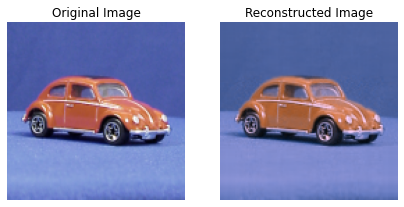

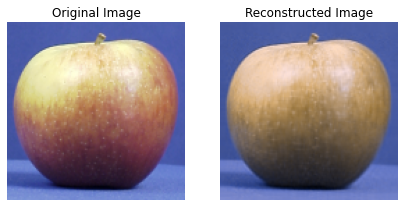

In [133]:
# Evaluate results

# Car
tensor_res_car = residual_tensor(tensor_car, tensor_tkd_car)
rel_error_car = tensor_res_car.frob_norm / tensor_car.frob_norm

print("Relative error of approximation of car= {}".format(rel_error_car))

tensor_rec_car = tensor_tkd_car.reconstruct()
plot_tensors(tensor_car, tensor_rec_car)

# Apple
tensor_res_apple = residual_tensor(tensor_apple, tensor_tkd_apple)
rel_error_apple = tensor_res_apple.frob_norm / tensor_apple.frob_norm

print("Relative error of approximation of apple= {}".format(rel_error_apple))

tensor_rec_apple = tensor_tkd_apple.reconstruct()
plot_tensors(tensor_apple, tensor_rec_apple)

**Include your explanations here**


### Solution: Part 2

In [134]:
# Create tensors from images
apple_top = get_image(item="apple", view="top")
tensor_apple_top = Tensor(apple_top)

apple_side = get_image(item="apple", view="side")
tensor_apple_side = Tensor(apple_side)

In [135]:
# Perform decomposition
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (50,50,2)
tensor_apple_top_tkd = algorithm.decompose(tensor_apple_top, ml_rank)
tensor_apple_side_tkd = algorithm.decompose(tensor_apple_side, ml_rank)

Relative error of approximation of apple from top 0.03706225838740828
Relative error of approximation for apple from side = 0.0657469040602634


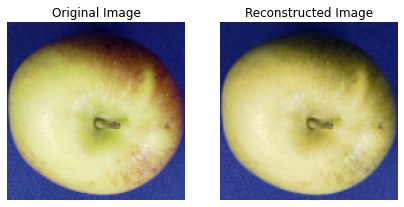

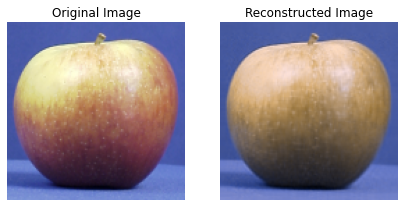

In [136]:
# Evaluate results
tensor_apple_top_res = residual_tensor(tensor_apple_top, tensor_apple_top_tkd)
rel_error_apple_top = tensor_apple_top_res.frob_norm / tensor_apple_top.frob_norm
print("Relative error of approximation of apple from top {}".format(rel_error_apple_top))

tensor_apple_side_res = residual_tensor(tensor_apple_side, tensor_apple_side_tkd)
rel_error_apple_side = tensor_apple_side_res.frob_norm / tensor_apple_side.frob_norm
print("Relative error of approximation for apple from side = {}".format(rel_error_apple_side))

# Reconstruction
tensor_apple_top_rec = tensor_apple_top_tkd.reconstruct()
plot_tensors(tensor_apple_top, tensor_apple_top_rec)

tensor_apple_side_rec = tensor_apple_side_tkd.reconstruct()
plot_tensors(tensor_apple_side, tensor_apple_side_rec)

**Include your explanations here**


### Solution: Part 3

Decreasing the channel mode's multi-linear rank to 1 simplifies the image to a 2-dimensional matrix, using shades of the dominant color for reconstruction. This results in an image like a grayscale version but with a single color, determined by mixing the original colors based on their informational value. This simplification might be useful for certain analytical purposes to reduce the fidelity of the reconstructed image to the original, while preserving essential visual details.

The following implementation demonstrates that the reconstructed image is indeed created using just a single color, similar to a grayscale image.

Relative error of approximation = 0.2544471822623988


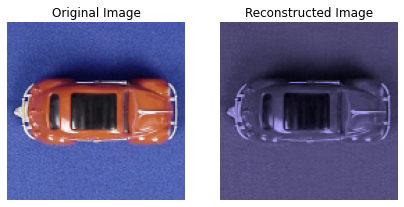

In [137]:
# Perform decomposition
item = get_image(item="car", view="top")
tensor = Tensor(item)
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (50,50,1)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Evaluate results
tensor_res = residual_tensor(tensor, tensor_tkd)
rel_error = tensor_res.frob_norm / tensor.frob_norm
print("Relative error of approximation = {}".format(rel_error))

# Reconstruction
tensor_rec = tensor_tkd.reconstruct()
plot_tensors(tensor, tensor_rec)
